In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns


In [34]:
# Zobrazení prvních řádků a sloupců obou souborů
wires_in_df = pd.read_csv("./data/wires_in")
wires_out_df = pd.read_csv("./data/wires_out")

# Přidání směru a potřebných sloupců
wires_in_df["Beneficiary"] = wires_in_df["Account"]
wires_in_df["Direction"] = "in"

wires_out_df["Originator"] = wires_out_df["Account"]
wires_out_df["Direction"] = "out"


In [38]:
# Spojení dat
combined_df = pd.concat([wires_in_df, wires_out_df], ignore_index=True)

# Převod ID sloupců na string
for col in ["Account", "Originator", "Beneficiary"]:
    combined_df[col] = combined_df[col].astype(str)

# Výběr transakcí pro účet 10004000
account_id = "10004000"
account_in_preview = combined_df[
    (combined_df["Account"] == account_id) |
    (combined_df["Originator"] == account_id) |
    (combined_df["Beneficiary"] == account_id)
].copy()

# Statistika výskytu
account_in_account_col = (combined_df["Account"] == account_id).sum()
account_as_originator = (combined_df["Originator"] == account_id).sum()
account_as_beneficiary = (combined_df["Beneficiary"] == account_id).sum()

# Kreditní a debetní výběr
credit_df = combined_df[combined_df["Beneficiary"] == account_id].copy()
debit_df = combined_df[combined_df["Originator"] == account_id].copy()

# Náhled
credit_df.head(), debit_df.head(), account_in_preview.head()

(      Account Originator  Amount        Date Beneficiary Direction
 120  10004000       BLXK   19141  2000-01-02    10004000        in
 270  10004000       BLWI   16629  2000-01-04    10004000        in
 271  10004000       ADVI   17681  2000-01-04    10004000        in
 317  10004000       CKVT   19688  2000-01-04    10004000        in
 389  10004000       AVVY   19854  2000-01-05    10004000        in,
        Account Originator  Amount        Date Beneficiary Direction
 4983  10004000   10004000   17165  2000-01-01        CCLC       out
 5175  10004000   10004000   11013  2000-01-03        CCLC       out
 5176  10004000   10004000   15343  2000-01-03        BLWI       out
 5203  10004000   10004000   14958  2000-01-03        BGHY       out
 5204  10004000   10004000   15156  2000-01-03        BLXK       out,
       Account Originator  Amount        Date Beneficiary Direction
 120  10004000       BLXK   19141  2000-01-02    10004000        in
 270  10004000       BLWI   16629  2000-

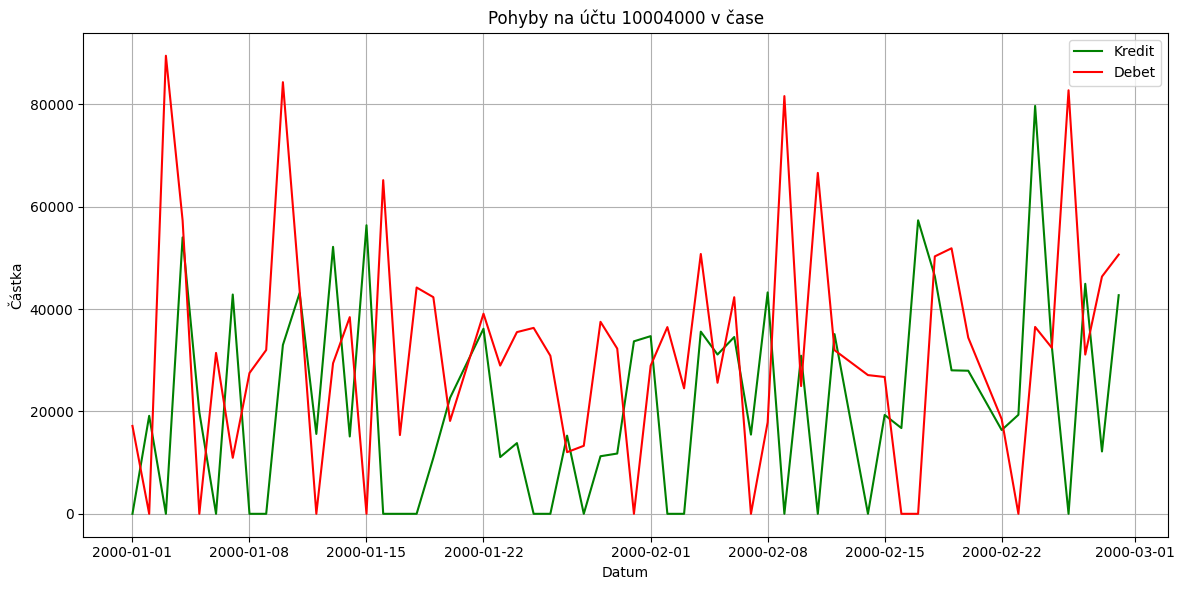

In [39]:
# Převod datumu
credit_df["Date"] = pd.to_datetime(credit_df["Date"])
debit_df["Date"] = pd.to_datetime(debit_df["Date"])

# Součty po dnech
credit_time_series = credit_df.groupby("Date")["Amount"].sum().rename("Kredit")
debit_time_series = debit_df.groupby("Date")["Amount"].sum().rename("Debet")
time_series = pd.concat([credit_time_series, debit_time_series], axis=1).fillna(0)

# Graf
plt.figure(figsize=(12, 6))
plt.plot(time_series.index, time_series["Kredit"], label="Kredit", color='green')
plt.plot(time_series.index, time_series["Debet"], label="Debet", color='red')
plt.title("Pohyby na účtu 10004000 v čase")
plt.xlabel("Datum")
plt.ylabel("Částka")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


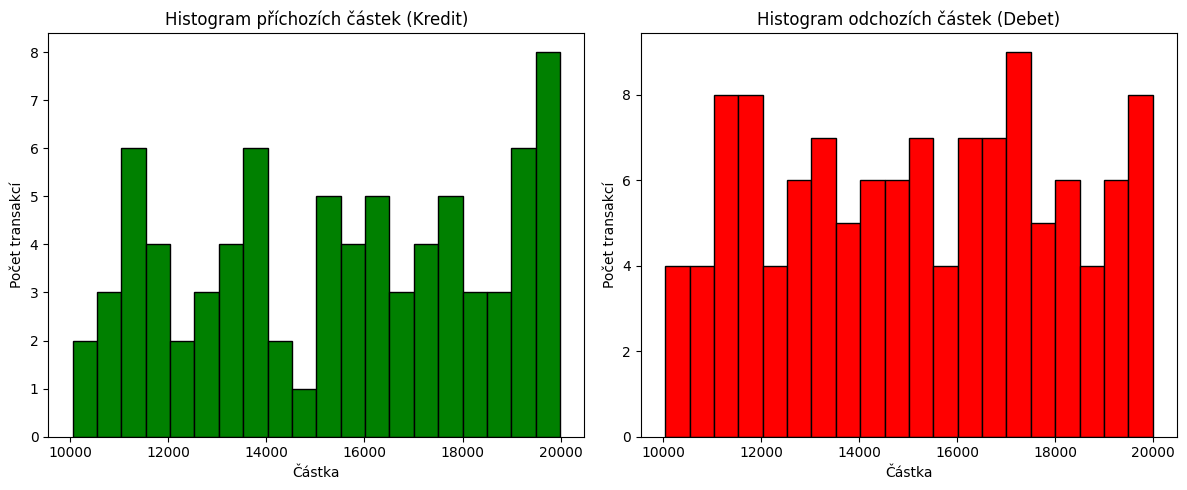

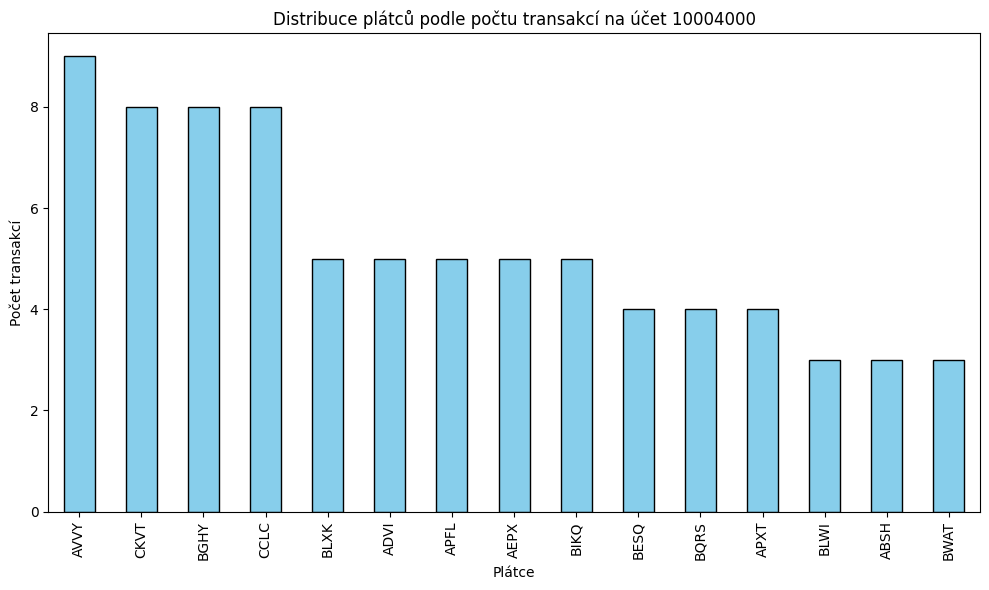

In [40]:
# Histogram částek pro příchozí i odchozí transakce
plt.figure(figsize=(12, 5))

# Histogram kreditních částek
plt.subplot(1, 2, 1)
plt.hist(credit_df["Amount"], bins=20, color='green', edgecolor='black')
plt.title("Histogram příchozích částek (Kredit)")
plt.xlabel("Částka")
plt.ylabel("Počet transakcí")

# Histogram debetních částek
plt.subplot(1, 2, 2)
plt.hist(debit_df["Amount"], bins=20, color='red', edgecolor='black')
plt.title("Histogram odchozích částek (Debet)")
plt.xlabel("Částka")
plt.ylabel("Počet transakcí")

plt.tight_layout()
plt.show()

# Distribuce plátců podle počtu transakcí
payer_distribution = credit_df["Originator"].value_counts()

plt.figure(figsize=(10, 6))
payer_distribution.plot(kind="bar", color='skyblue', edgecolor='black')
plt.title("Distribuce plátců podle počtu transakcí na účet 10004000")
plt.xlabel("Plátce")
plt.ylabel("Počet transakcí")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [41]:
# Statistiky plátců (Originator) → účet 10004000
payers_stats = (
    credit_df.groupby("Originator")["Amount"]
    .agg(["count", "sum", "mean", "min", "max", "std"])
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .rename(columns={
        "Originator": "Plátce",
        "count": "Počet",
        "sum": "Součet",
        "mean": "Průměr",
        "min": "Min",
        "max": "Max",
        "std": "Směrodatná odchylka"
    })
)

# Statistiky příjemců (Beneficiary) ← z účtu 10004000
receivers_stats = (
    debit_df.groupby("Beneficiary")["Amount"]
    .agg(["count", "sum", "mean", "min", "max", "std"])
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .rename(columns={
        "Beneficiary": "Příjemce",
        "count": "Počet",
        "sum": "Součet",
        "mean": "Průměr",
        "min": "Min",
        "max": "Max",
        "std": "Směrodatná odchylka"
    })
)

In [42]:

#Výpis statistik do konzole Jupyter notebooku

print("Statistiky plátců → účet 10004000 (TOP 15 podle částky):")
display(payers_stats.head(15))

print("\nStatistiky příjemců ← z účtu 10004000 (TOP 15 podle částky):")
display(receivers_stats.head(15))


Statistiky plátců → účet 10004000 (TOP 15 podle částky):


,Plátce,Počet,Součet,Průměr,Min,Max,Směrodatná odchylka
0,AVVY,9,148467,16496.333333,11773,19986,2976.505165
1,CKVT,8,129544,16193.000000,11083,19688,3600.212335
2,CCLC,8,117658,14707.250000,10350,18847,3023.863931
3,BGHY,8,115699,14462.375000,10942,19855,3121.778153
4,AEPX,5,81430,16286.000000,11122,19313,3197.516614
5,BLXK,5,78681,15736.200000,10928,19775,4408.281037
6,ADVI,5,76799,15359.800000,11672,19876,3329.830731
7,APFL,5,70899,14179.800000,11572,19260,3003.086279
8,BIKQ,5,68729,13745.800000,11196,17572,2595.040308
9,APXT,4,67961,16990.250000,14917,19343,1919.019085



Statistiky příjemců ← z účtu 10004000 (TOP 15 podle částky):


,Příjemce,Počet,Součet,Průměr,Min,Max,Směrodatná odchylka
0,BIKQ,13,195547,15042.076923,10938,19756,2608.688670
1,BWAT,11,183799,16709.000000,10039,19992,3406.066705
2,APFL,11,167209,15200.818182,10241,18071,2783.505733
3,ABSH,10,164061,16406.100000,11685,19834,2358.539965
4,AEPX,10,154906,15490.600000,11094,19522,3425.903813
5,BESQ,9,129235,14359.444444,10097,19435,3385.531646
6,BGHY,8,125622,15702.750000,12110,19248,2710.334178
7,APXT,8,116440,14555.000000,10298,17623,2240.927614
8,CCLC,8,116200,14525.000000,11013,19498,3120.549036
9,BLXK,8,115068,14383.500000,11200,19672,3223.991758


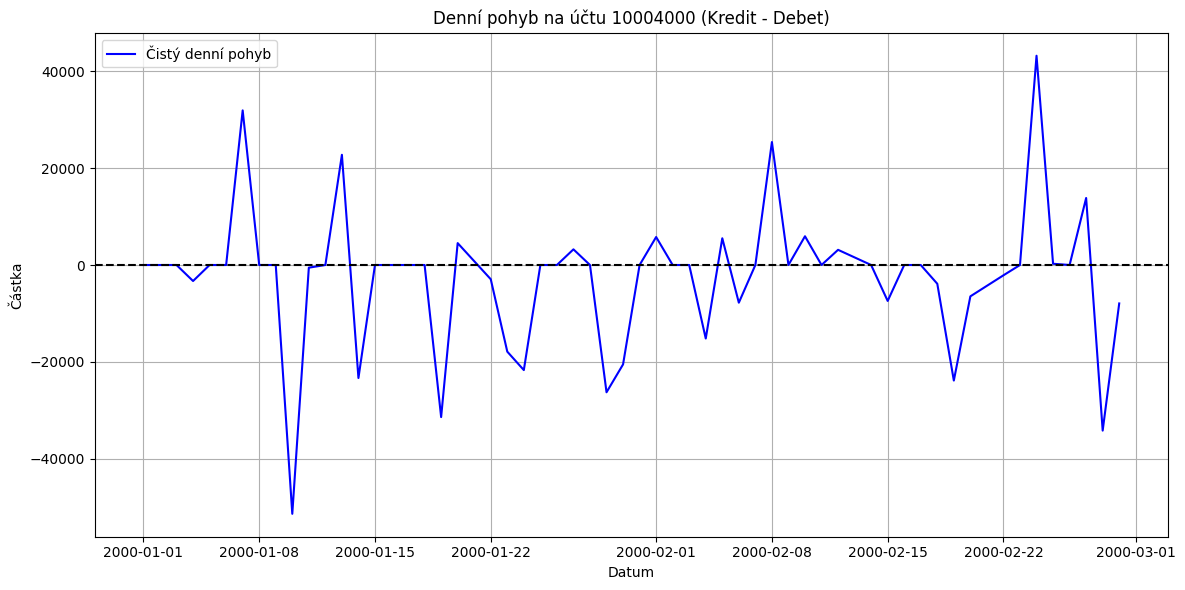

{'Nejvyšší příliv': (datetime.date(2000, 2, 24), np.float64(43173.0)),
 'Nejvyšší odliv': (datetime.date(2000, 1, 10), np.float64(-51333.0)),
 'Průměrný denní pohyb': np.float64(-2500.6491228070176),
 'Směrodatná odchylka': np.float64(14822.625152462064),
 '95. percentil (horní hranice)': np.float64(23262.599999999988),
 '5. percentil (dolní hranice)': np.float64(-27281.6),
 'Počet extrémních dnů': 6,
 'Extrémní dny': Date
 2000-01-07    31899.0
 2000-01-10   -51333.0
 2000-01-19   -31376.0
 2000-02-08    25365.0
 2000-02-24    43173.0
 2000-02-28   -34164.0
 Name: Čistý pohyb, dtype: float64}

In [46]:
# Denní pohyby: rozdíl kredit - debet každý den
daily_movement = (credit_time_series - debit_time_series).rename("Čistý pohyb")

# Vyplnění chybějících dnů nulou
daily_movement = daily_movement.fillna(0)

# Vykreslení čistého denního pohybu
plt.figure(figsize=(12, 6))
plt.plot(daily_movement.index, daily_movement.values, label="Čistý denní pohyb", color='blue')
plt.axhline(0, color='black', linestyle='--')
plt.title("Denní pohyb na účtu 10004000 (Kredit - Debet)")
plt.xlabel("Datum")
plt.ylabel("Částka")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Výpočet základních statistik pro denní pohyb
max_inflow_day = daily_movement.idxmax()
max_inflow_value = daily_movement.max()

max_outflow_day = daily_movement.idxmin()
max_outflow_value = daily_movement.min()

mean_movement = daily_movement.mean()
std_movement = daily_movement.std()

# Označení extrémních dnů (95. a 5. percentil)
threshold_high = daily_movement.quantile(0.95)
threshold_low = daily_movement.quantile(0.05)

extreme_days = daily_movement[(daily_movement >= threshold_high) | (daily_movement <= threshold_low)]

# Výpis analýzy
{
    "Nejvyšší příliv": (max_inflow_day.date(), max_inflow_value),
    "Nejvyšší odliv": (max_outflow_day.date(), max_outflow_value),
    "Průměrný denní pohyb": mean_movement,
    "Směrodatná odchylka": std_movement,
    "95. percentil (horní hranice)": threshold_high,
    "5. percentil (dolní hranice)": threshold_low,
    "Počet extrémních dnů": extreme_days.shape[0],
    "Extrémní dny": extreme_days
}


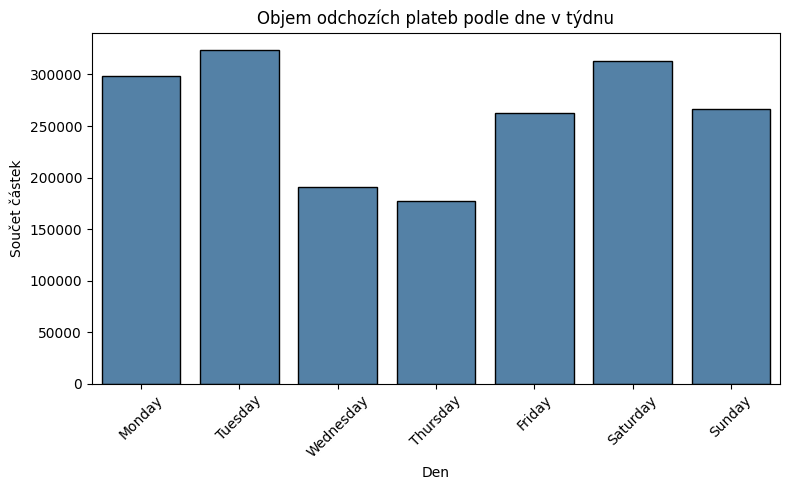

,B,Amount_out,Date_out,Amount_in,Date_in
0,CCLC,17165,2000-01-01,13815,2000-01-24
1,CCLC,17165,2000-01-01,11249,2000-01-29
2,CCLC,17165,2000-01-01,18010,2000-01-31
3,CCLC,17165,2000-01-01,10350,2000-02-04
4,CCLC,17165,2000-01-01,13563,2000-02-04
...,...,...,...,...,...
525,BWAT,19772,2000-02-20,17359,2000-02-24
541,APFL,18071,2000-02-24,19260,2000-02-27
566,BQRS,17192,2000-02-26,14280,2000-02-27
578,BGHY,18167,2000-02-27,11075,2000-02-29


,Účet,Počet příchozích,Počet odchozích,Celkem
1,BIKQ,5,13,18
5,CCLC,8,8,16
11,BGHY,8,8,16
14,APFL,5,11,16
6,AVVY,9,6,15
9,AEPX,5,10,15
12,BWAT,3,11,14
0,ABSH,3,10,13
8,CKVT,8,5,13
10,BESQ,4,9,13


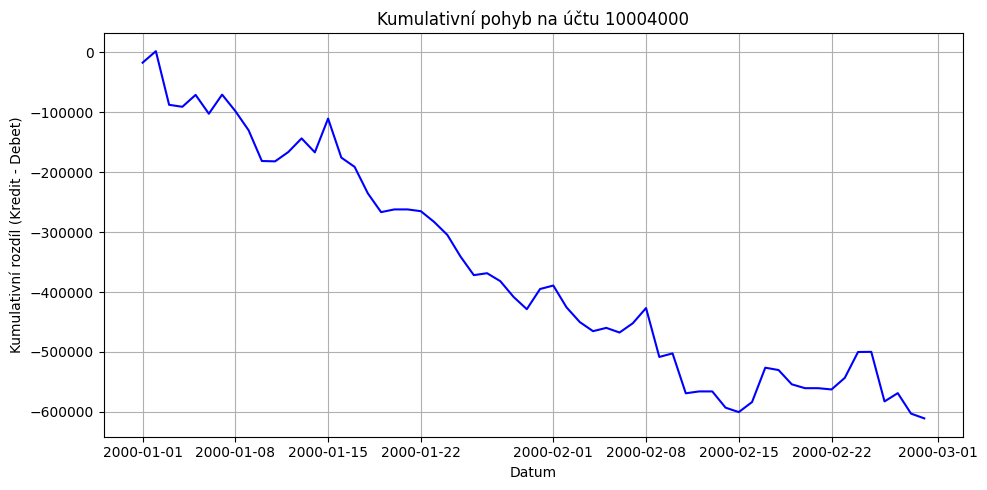

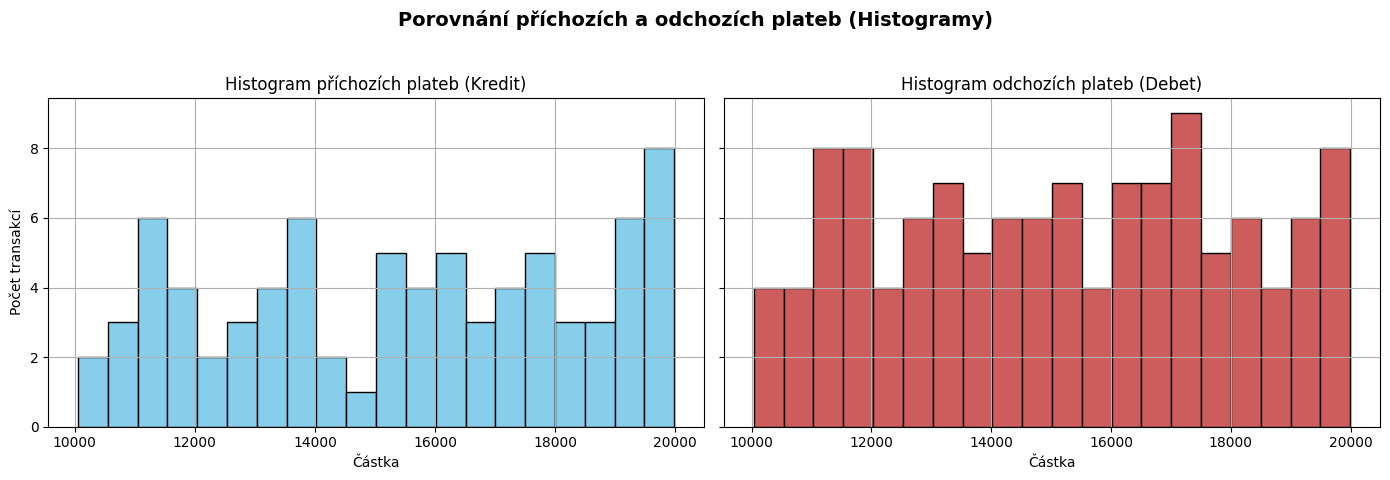

In [52]:
import seaborn as sns
from matplotlib.colors import LogNorm

# 1. 🔁 Podezřelé kruhové transakce (2-stupňové zpětné platby)
# Krok 1: účet 10004000 → B → C
outgoing = debit_df[["Beneficiary", "Amount", "Date"]].copy()
outgoing.columns = ["B", "Amount", "Date"]
incoming = credit_df[["Originator", "Amount", "Date"]].copy()
incoming.columns = ["B", "Amount", "Date"]

# Najdeme účty, které poslaly peníze 10004000 A POZDĚJI obdržely od něj platbu (2-krokový cyklus)
circle_accounts = pd.merge(outgoing, incoming, on="B", suffixes=("_out", "_in"))
circle_accounts_filtered = circle_accounts[circle_accounts["Date_out"] < circle_accounts["Date_in"]]

# 3. 📈 Kumulativní pohyb
daily_balance = (credit_time_series - debit_time_series).cumsum()

# 4. 📅 Heatmapa podle dne v týdnu
combined_df["Date"] = pd.to_datetime(combined_df["Date"])
combined_df["Weekday"] = combined_df["Date"].dt.day_name()
combined_df["Direction"] = combined_df["Direction"].fillna("")

weekday_volume = (
    combined_df[combined_df["Originator"] == account_id]
    .groupby("Weekday")["Amount"]
    .sum()
    .reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
)

# 5. 🎯 Top N účtů s obousměrným tokem
credit_partners = set(credit_df["Originator"])
debit_partners = set(debit_df["Beneficiary"])
bidirectional_partners = credit_partners & debit_partners

bidirectional_df = pd.DataFrame(bidirectional_partners, columns=["Účet"])
bidirectional_df["Počet příchozích"] = bidirectional_df["Účet"].map(credit_df["Originator"].value_counts())
bidirectional_df["Počet odchozích"] = bidirectional_df["Účet"].map(debit_df["Beneficiary"].value_counts())
bidirectional_df["Celkem"] = bidirectional_df["Počet příchozích"] + bidirectional_df["Počet odchozích"]
bidirectional_df = bidirectional_df.sort_values(by="Celkem", ascending=False)


# Heatmapa objemu podle dne v týdnu
plt.figure(figsize=(8, 5))
sns.barplot(x=weekday_volume.index, y=weekday_volume.values, color="steelblue", edgecolor='black')
plt.title("Objem odchozích plateb podle dne v týdnu")
plt.ylabel("Součet částek")
plt.xlabel("Den")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Výpis kruhových transakcí a obousměrných partnerů
display(circle_accounts_filtered, bidirectional_df.head(10))


# --- GRAFY ---
# 3. Kumulativní pohyb
# Agregace podle data (součet částek za každý den)
credit_daily = credit_df.groupby("Date")["Amount"].sum()
debit_daily = debit_df.groupby("Date")["Amount"].sum()

full_range = pd.date_range(start=min(credit_daily.index.min(), debit_daily.index.min()),
                           end=max(credit_daily.index.max(), debit_daily.index.max()))

# Znovu vytvoříme denní série s nulami pro chybějící dny
credit_full = credit_daily.reindex(full_range, fill_value=0)
debit_full = debit_daily.reindex(full_range, fill_value=0)
# Výpočet kumulativního rozdílu
credit_cumsum = credit_full.cumsum()
debit_cumsum = debit_full.cumsum()
cumulative_balance = credit_cumsum - debit_cumsum


plt.figure(figsize=(10, 5))
plt.plot(cumulative_balance.index, cumulative_balance.values, color='blue')
plt.title("Kumulativní pohyb na účtu 10004000")
plt.xlabel("Datum")
plt.ylabel("Kumulativní rozdíl (Kredit - Debet)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Histogram částek pro kreditní a debetní platby – vedle sebe
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Histogram kreditních (příchozích) plateb
axs[0].hist(credit_df["Amount"], bins=20, color='skyblue', edgecolor='black')
axs[0].set_title("Histogram příchozích plateb (Kredit)")
axs[0].set_xlabel("Částka")
axs[0].set_ylabel("Počet transakcí")
axs[0].grid(True)

# Histogram debetních (odchozích) plateb
axs[1].hist(debit_df["Amount"], bins=20, color='indianred', edgecolor='black')
axs[1].set_title("Histogram odchozích plateb (Debet)")
axs[1].set_xlabel("Částka")
axs[1].grid(True)

plt.suptitle("Porovnání příchozích a odchozích plateb (Histogramy)", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


{('BLXK', '10004000'): Text(0.33484504439977913, -0.1772349498269467, '17827'),
 ('10004000', 'CCLC'): Text(0.15621151994617422, 0.30009757162525996, '14441'),
 ('10004000', 'BLWI'): Text(0.37881194967259196, 0.30846451895805793, '15245'),
 ('10004000',
  'BGHY'): Text(-0.4482878139437974, -0.04503280076119098, '18167'),
 ('10004000', 'BLXK'): Text(0.33484504439977913, -0.1772349498269467, '19672'),
 ('10004000',
  'AEPX'): Text(-0.20914739086569364, 0.21599369740320365, '12649'),
 ('10004000', 'ABSH'): Text(0.2715890346274458, -0.21985932047423995, '19834'),
 ('10004000', 'BQRS'): Text(-0.14766572738470077, 0.3415184689381605, '17192'),
 ('10004000',
  'APFL'): Text(0.015682110554220974, -0.33490087612764036, '11697'),
 ('10004000', 'BIKQ'): Text(-0.4805921816338196, 0.03464641438676757, '19756'),
 ('10004000', 'ADVI'): Text(0.0811110157123745, 0.5037799167173831, '19060'),
 ('10004000',
  'APXT'): Text(-0.03179210705743833, -0.35172971984697493, '14535'),
 ('10004000', 'BWAT'): Text(

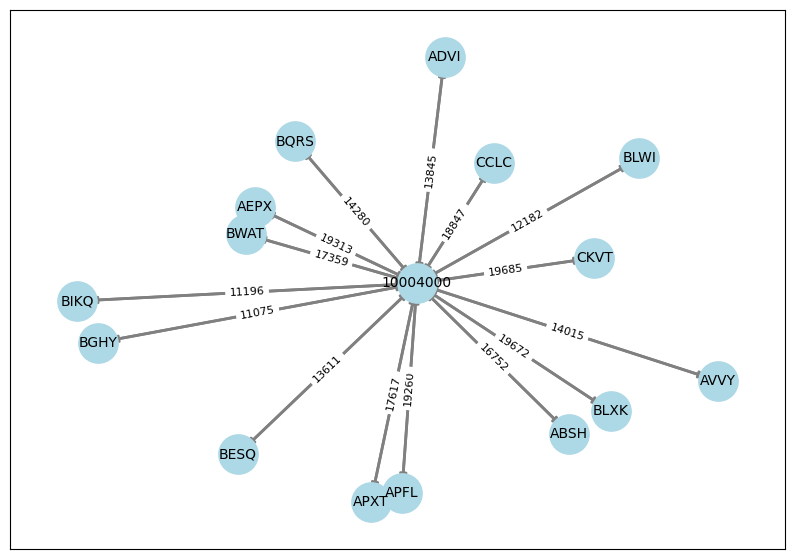

In [53]:
# Filtrování transakcí pouze mezi účtem 10004000 a obousměrnými účty
bidirectional_ids = set(bidirectional_df["Účet"])

# Transakce mezi 10004000 a obousměrnými partnery
network_df = combined_df[
    ((combined_df["Originator"] == account_id) & (combined_df["Beneficiary"].isin(bidirectional_ids))) |
    ((combined_df["Beneficiary"] == account_id) & (combined_df["Originator"].isin(bidirectional_ids)))
]

# Vytvoření grafu
G = nx.DiGraph()
for _, row in network_df.iterrows():
    G.add_edge(row["Originator"], row["Beneficiary"], weight=row["Amount"])

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, seed=42)

# Vykreslení uzlů a hran
nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=10)

# Vykreslení hran a popisků částek
weights = [d["weight"] for _, _, d in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, edge_color='gray', width=2, arrows=True)
edge_labels = {(u, v): f"{d['weight']}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)





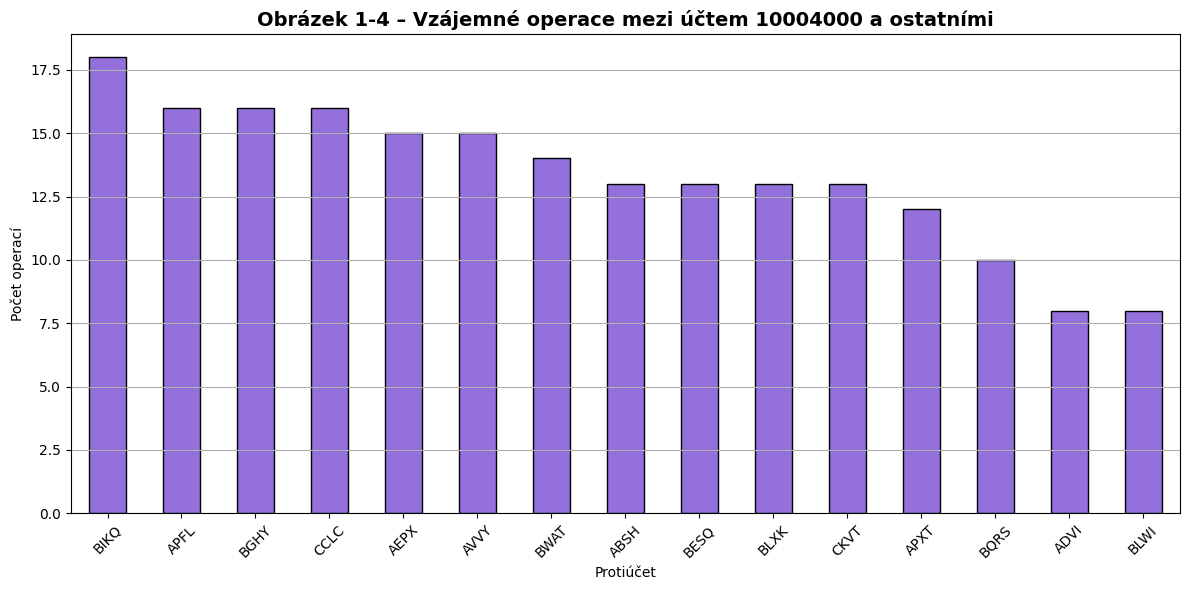

In [54]:
# Obrázek 1-4 – sloupcový graf vzájemných operací (četnosti) mezi účtem 10004000 a ostatními

# Spočítáme četnost interakcí s ostatními účty (příchozí + odchozí)
in_counts_named = credit_df["Originator"].value_counts()
out_counts_named = debit_df["Beneficiary"].value_counts()

# Sloučení počtů pro obousměrné zobrazení
interaction_counts = (in_counts_named + out_counts_named).sort_values(ascending=False)

# Vybereme top 15 partnerů
interaction_counts_top = interaction_counts.head(15)

# Sloupcový graf
plt.figure(figsize=(12, 6))
interaction_counts_top.plot(kind="bar", color="mediumpurple", edgecolor='black')
plt.title("Obrázek 1-4 – Vzájemné operace mezi účtem 10004000 a ostatními", fontsize=14, fontweight='bold')
plt.xlabel("Protiúčet")
plt.ylabel("Počet operací")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


/Users/pvacha/projects/tul/dm-money-laundering/jlab_env/lib/python3.9/site-packages/mpl_toolkits/mplot3d/art3d.py:1239: RuntimeWarning: divide by zero encountered in matmul
  shade = ((normals / np.linalg.norm(normals, axis=1, keepdims=True))
/Users/pvacha/projects/tul/dm-money-laundering/jlab_env/lib/python3.9/site-packages/mpl_toolkits/mplot3d/art3d.py:1239: RuntimeWarning: overflow encountered in matmul
  shade = ((normals / np.linalg.norm(normals, axis=1, keepdims=True))


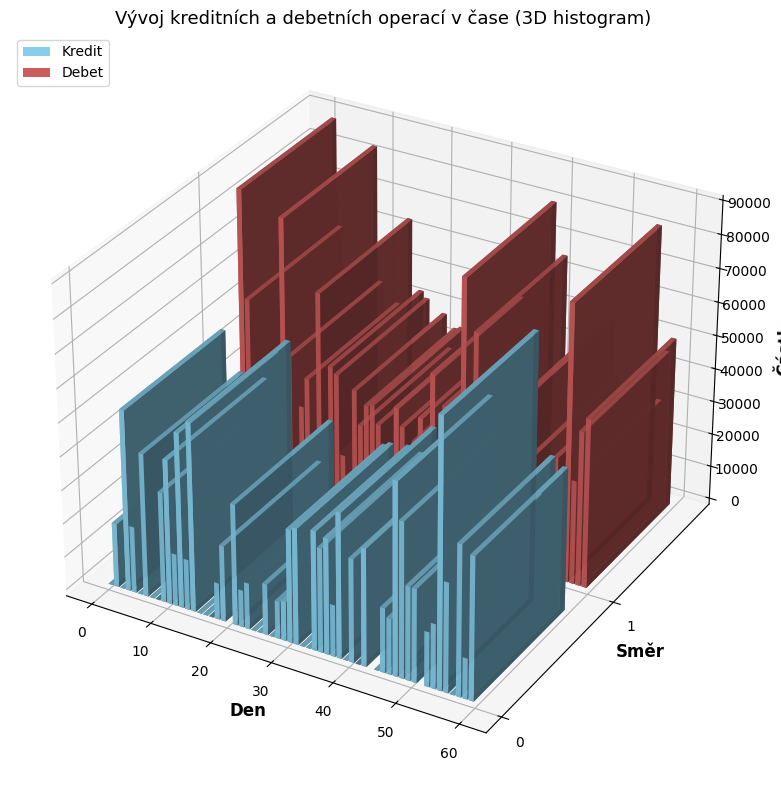

In [55]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

credit_hist = credit_df.groupby("Date")["Amount"].sum().rename("Kredit")
debit_hist = debit_df.groupby("Date")["Amount"].sum().rename("Debet")
hist_df = pd.concat([credit_hist, debit_hist], axis=1).fillna(0)


# Převod dat na formát vhodný pro 3D histogram
hist_df_reset = hist_df.reset_index()
hist_df_reset["Day"] = (hist_df_reset["Date"] - hist_df_reset["Date"].min()).dt.days

#ručně vytvoříme legendu pomocí patchů místo automatického převzetí z bar3d
from matplotlib.patches import Patch

# Znovu vytvoření grafu
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

x = hist_df_reset["Day"].values
y_kredit = np.zeros_like(x)
y_debet = np.ones_like(x)
z = np.zeros_like(x)

dx = dy = 0.8
dz_kredit = hist_df_reset["Kredit"].values
dz_debet = hist_df_reset["Debet"].values

# Bar3D pro kredit a debet
ax.bar3d(x, y_kredit, z, dx, dy, dz_kredit, color='skyblue', alpha=0.9)
ax.bar3d(x, y_debet, z, dx, dy, dz_debet, color='indianred', alpha=0.9)

# Osy
ax.set_xlabel('Den', fontsize=12, fontweight='bold')
ax.set_ylabel('Směr', fontsize=12, fontweight='bold')
ax.set_zlabel('Částka', fontsize=12, fontweight='bold', labelpad=10)
ax.set_yticks([0, 1])

# Ruční legenda
legend_patches = [
    Patch(facecolor='skyblue', label='Kredit'),
    Patch(facecolor='indianred', label='Debet')
]
plt.legend(handles=legend_patches, loc='upper left')

plt.title('Vývoj kreditních a debetních operací v čase (3D histogram)', fontsize=13)
plt.tight_layout()
plt.show()


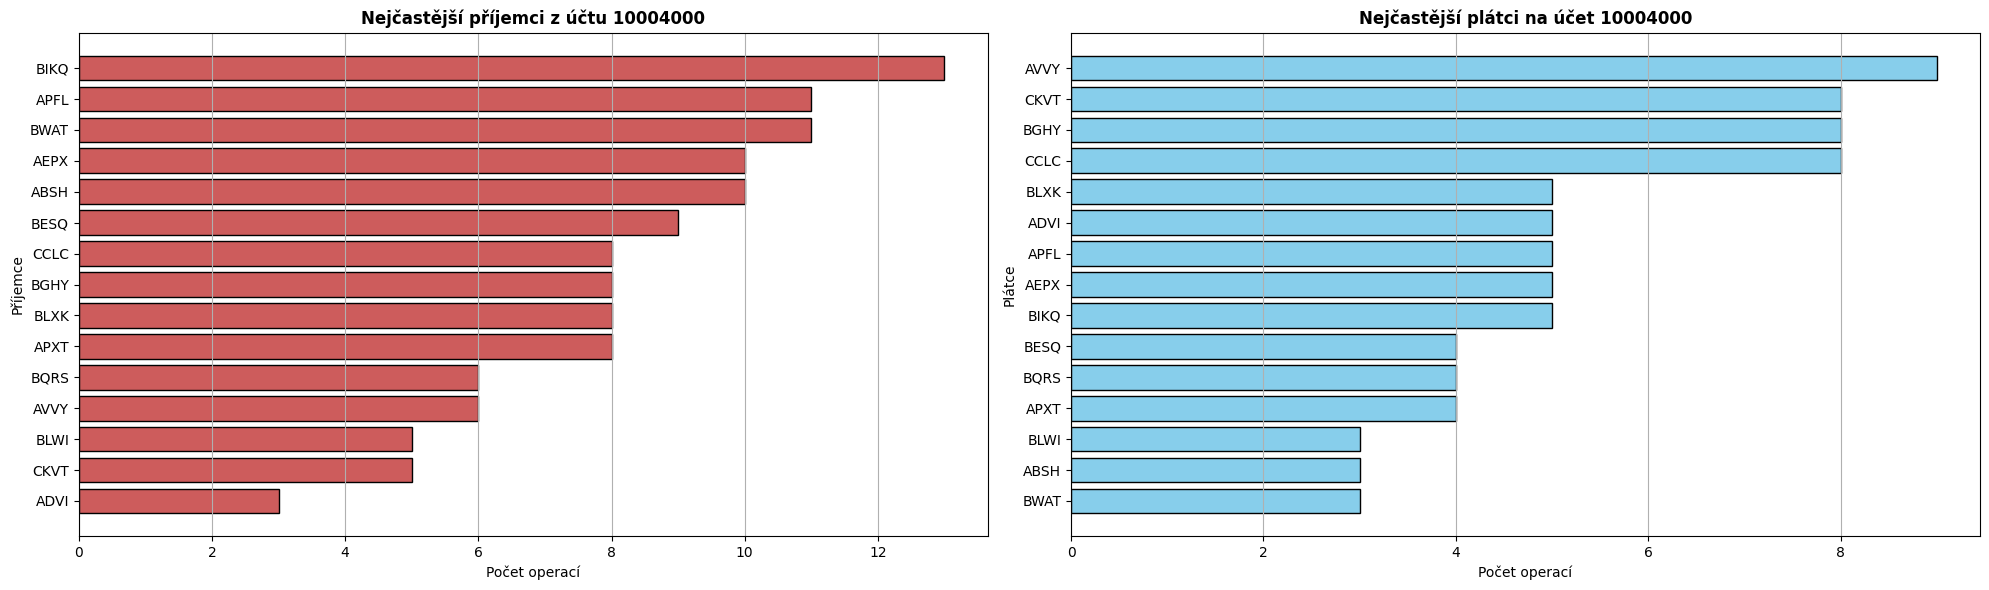

In [57]:
debit_counts = debit_df["Beneficiary"].value_counts().head(20)

# Obrázek 1-4B – podle odesilatelů (Originator), kdo posílá účtu 10004000
credit_counts = credit_df["Originator"].value_counts().head(20)

fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=False)

# Graf 1 – Příjemci (Beneficiary)
axs[0].barh(debit_counts.index[::-1], debit_counts.values[::-1], color='indianred', edgecolor='black')
axs[0].set_title("Nejčastější příjemci z účtu 10004000", fontweight='bold')
axs[0].set_xlabel("Počet operací")
axs[0].set_ylabel("Příjemce")
axs[0].grid(True, axis='x')

# Graf 2 – Odesilatelé (Originator)
axs[1].barh(credit_counts.index[::-1], credit_counts.values[::-1], color='skyblue', edgecolor='black')
axs[1].set_title("Nejčastější plátci na účet 10004000", fontweight='bold')
axs[1].set_xlabel("Počet operací")
axs[1].set_ylabel("Plátce")
axs[1].grid(True, axis='x')

plt.tight_layout()
plt.show()
